/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/esil/rsm_helper/model_property.py:75: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  self.lats, self.lons = transform(projection, 'EPSG:4326',grid_x, grid_y)


X - axis Key_Periods: ['W126']
Y - axis Key_Periods: ['W126']
Directory already exists: /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_CompareMap
Selected key periods: ['W126']


  0%|          | 0/1 [00:00<?, ?it/s]

Processing key period: W126


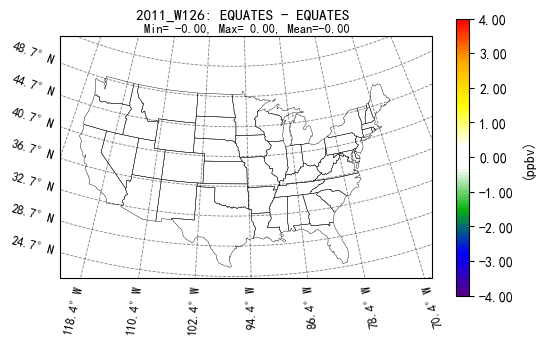

The data fusion plot for 2011_W126: EQUATES - EQUATES is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_CompareMap/2011_W126: EQUATES - EQUATES.png


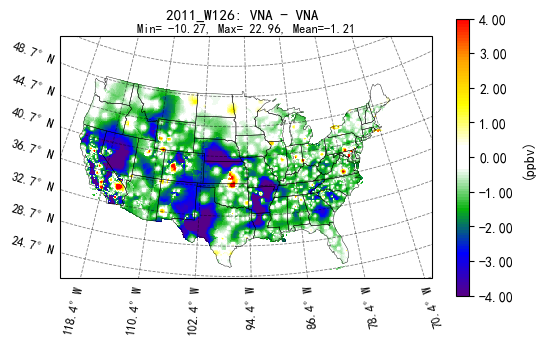

The data fusion plot for 2011_W126: VNA - VNA is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_CompareMap/2011_W126: VNA - VNA.png
Done!


In [3]:
import os
import re
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import itertools

# for show maps
from esil.rsm_helper.model_property import model_attribute
from esil.map_helper import get_multiple_data, show_maps
import cmaps

cmap_conc = cmaps.WhiteBlueGreenYellowRed
cmap_delta = cmaps.ViBlGrWhYeOrRe


def extract_key_period(period):
    """
    Extract key period (e.g., JFM, AMJ) from the full period string.
    """
    key_periods = ["DJF", "MAM", "JJA", "SON", 'Annual', 'Apr-Sep', 'top-10', '98th','W126']
    for key in key_periods:
        if key in period:
            return key
    return None


def get_year(filename):
    """
    Extract the year from the filename (assuming the year is in the range 2011 - 2020).
    """
    match = re.search(r"(20[1-2][0-9])", filename)
    if match:
        return match.group(0)
    return None


def get_dataset_label(variable, filename):
    """
    Get the dataset label based on variable and filename.
    """
    if variable == 'vna_ozone':
        return "VNA"
    elif variable == 'evna_ozone':
        return "eVNA"
    elif variable == 'avna_ozone':
        return "aVNA"
    elif variable == 'ds_ozone':
        return "Downscaler"
    elif variable =='model':
        return "EQUATES"
    elif variable == 'harvard_ml':
        return "Harvard ML"
    return "unknown"


def plot_us_map(
        fusion_output_file_x,
        fusion_output_file_y,
        model_file,
        save_path=None,
        boundary_json_file="/DeepLearning/mnt/Devin/boundary/USA_State.json",
        comparisons=None,
        variable_settings=None,
        selected_periods=None
):
    """
    description: plot the US map with different data fusion results
    @param {string} fusion_output_file_x: the data fusion output file for the x - axis
    @param {string} fusion_output_file_y: the data fusion output file for the y - axis
    @param {string} model_file: the model file used for data fusion
    @param {string} save_path: the path to save the plot
    @param {string} boundary_json_file: the boundary file for the US map
    @param {list} comparisons: list of tuples, each tuple contains two variable names for comparison
    @param {dict} variable_settings: dictionary of settings for each comparison
    @param {list} selected_periods: 要画图的指标列表，如 ["DJF", "JJA"]
    @return None
    """
    # Load model attributes
    mp = model_attribute(model_file)
    proj, longitudes, latitudes = mp.projection, mp.lons, mp.lats

    # Read both x - axis and y - axis data
    df_data_x = pd.read_csv(fusion_output_file_x)
    df_data_y = pd.read_csv(fusion_output_file_y)

    # Check if the required columns exist
    if "Period" not in df_data_x.columns or "Period" not in df_data_y.columns:
        print("The data fusion files do not contain the Period column!")
        return

    # Extract key periods (e.g., JFM, AMJ) from the Period column
    df_data_x["Key_Period"] = df_data_x["Period"].apply(extract_key_period)
    df_data_y["Key_Period"] = df_data_y["Period"].apply(extract_key_period)

    # Drop rows where Key_Period is None
    df_data_x = df_data_x.dropna(subset=["Key_Period"])
    df_data_y = df_data_y.dropna(subset=["Key_Period"])

    # Debug: Print unique Key_Periods
    print("X - axis Key_Periods:", df_data_x["Key_Period"].unique())
    print("Y - axis Key_Periods:", df_data_y["Key_Period"].unique())

    # Extract year from filenames
    year_x = get_year(fusion_output_file_x)
    year_y = get_year(fusion_output_file_y)

    if year_x != year_y:
        print("Warning: The years in the input files do not match!")
        return

    year = year_x

    # Create save path
    save_path = os.path.join("/DeepLearning/mnt/shixiansheng/data_fusion/output", f"{year}_CompareMap")
    try:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
            print(f"Created directory: {save_path}")
        else:
            print(f"Directory already exists: {save_path}")
    except OSError as e:
        print(f"Error creating directory: {e}")
        return

    # 如果指定了画图指标，则只处理这些指标，否则处理所有指标
    if selected_periods:
        key_periods = [period for period in df_data_x["Key_Period"].unique() if period in selected_periods]
        print(f"Selected key periods: {key_periods}")
    else:
        key_periods = df_data_x["Key_Period"].unique()

    for key_period in tqdm(key_periods):
        print(f"Processing key period: {key_period}")
        # Filter data for the current key period
        df_x_period = df_data_x[df_data_x["Key_Period"] == key_period]
        df_y_period = df_data_y[df_data_y["Key_Period"] == key_period]

        if len(df_x_period) == 0 or len(df_y_period) == 0:
            print(f"No data found for period {key_period} in one of the files!")
            continue

        for variable_x, variable_y in comparisons:
            if variable_x not in df_x_period.columns or variable_y not in df_y_period.columns:
                print(f"Variable {variable_x} or {variable_y} not found in data files. Skipping...")
                continue

            # Get dataset labels
            dataset_label_x = get_dataset_label(variable_x, fusion_output_file_x)
            dataset_label_y = get_dataset_label(variable_y, fusion_output_file_y)

            # Generate title
            title = f"{year}_{key_period}: {dataset_label_y} - {dataset_label_x}"

            # Reshape data to match the grid
            grid_variable_x = df_x_period[variable_x].values.reshape(longitudes.shape)
            grid_variable_y = df_y_period[variable_y].values.reshape(longitudes.shape)

            # Calculate differences (y - x)
            grid_variable_diff = grid_variable_y - grid_variable_x

            # Get settings for the current comparison
            comparison_key = f"{variable_y}-{variable_x}"
            settings = variable_settings.get(comparison_key, variable_settings["default"])

            # Prepare data for plotting
            dict_data = {}
            get_multiple_data(
                dict_data,
                dataset_name=title,
                variable_name=f"",
                grid_x=longitudes,
                grid_y=latitudes,
                grid_concentration=grid_variable_diff,
                is_delta=settings.get('is_delta', True),
                cmap=settings.get('cmap_delta', cmap_delta)
            )

            # Plot the maps
            fig = show_maps(
                dict_data,
                unit=settings.get('unit', "ppbv"),
                cmap=settings.get('cmap_conc', cmap_conc),
                show_lonlat=settings.get('show_lonlat', True),
                projection=proj,
                is_wrf_out_data=settings.get('is_wrf_out_data', True),
                boundary_file=boundary_json_file,
                show_original_grid=settings.get('show_original_grid', True),
                panel_layout=settings.get('panel_layout', None),
                delta_map_settings=settings.get('delta_map_settings', {
                    "cmap": cmap_delta,
                    "value_range": (None, None),
                    "colorbar_ticks_num": None,
                    "colorbar_ticks_value_format": ".2f",
                    "value_format": ".2f"
                }),
                title_fontsize=settings.get('title_fontsize', 11),
                xy_title_fontsize=settings.get('xy_title_fontsize', 9),
                show_dependenct_colorbar=settings.get('show_dependenct_colorbar', True),
                show_domain_mean=settings.get('show_domain_mean', True)
            )

            # Save the plot with the new title
            if save_path is not None:
                save_file = os.path.join(save_path, f"{title}.png")
                fig.savefig(save_file, dpi=300, bbox_inches="tight")
                print(f"The data fusion plot for {title} is saved to {save_file}")


if __name__ == "__main__":
    # 输入文件
    fusion_output_file_y = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/W126/2011_W126_ST.csv"
    fusion_output_file_x = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/W126/2011_W126_ST_AtF_True.csv"
    # fusion_output_file_y = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/2011_Data_WithoutCV/2010_W126_ST.csv"
    # fusion_output_file_x = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/2011_Data_WithoutCV/2011_Data_WithoutCV_Exsame_Metrics.csv"

    # 其他代码
    model_file = r"/backupdata/data_EPA/EQUATES/EQUATES_data/HR2DAY_LST_ACONC_v532_cb6r3_ae7_aq_WR413_MYR_STAGE_2011_12US1_2011.nc"

    variables = ['model','vna_ozone', 'evna_ozone', 'avna_ozone', 'ds_ozone','harvard_ml']
    comparisons = list(itertools.combinations(variables, 2))
    comparisons = [('model','model'),('vna_ozone','vna_ozone')]
    

    # 为每个对比设置独立的绘图参数（统一设置）
    variable_settings = {
        'default': {
            'is_delta': True,
            'cmap_delta': cmaps.ViBlGrWhYeOrRe,
            'unit': "ppbv",
            'cmap_conc': cmaps.WhiteBlueGreenYellowRed,
            'show_lonlat': True,
            'is_wrf_out_data': True,
            'show_original_grid': True,
            'panel_layout': None,
            'delta_map_settings': {
                "cmap": cmaps.ViBlGrWhYeOrRe,
                "value_range": (-4, 4),
                "colorbar_ticks_num": None,
                "colorbar_ticks_value_format": ".2f",
                "value_format": ".2f"
            },
            'title_fontsize': 11,
            'xy_title_fontsize': 9,
            'show_dependenct_colorbar': True,
            'show_domain_mean': True
        }
    }

    # 指定画图的指标
    selected_periods = ['DJF','MAM','JJA','SON','Apr-Sep','Annual','top-10','W126']

    plot_us_map(
        fusion_output_file_x,
        fusion_output_file_y,
        model_file,
        comparisons=comparisons,
        variable_settings=variable_settings,
        selected_periods=selected_periods
    )
    print("Done!")
    